In [43]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

In [44]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn import metrics
import json

import warnings
warnings.filterwarnings("ignore")


sys.path.append('..')
from lib.line_notif import send_message
#from lib.utils import matrics_rotate
from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
from lib.utils import one_hot_encoder, apply_agg, multi_combine_categorical_feature
from lib.utils import import_data, get_split_indexer 

In [45]:


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [46]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
structures = pd.read_csv('../input/structures.csv')

In [47]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [48]:
test_id = test.id.values

In [49]:
ls -l ../submit/v003_101/

total 7878376
-rw-r--r--  1 kenichi.matsui  1522739515  67164134  8 27 02:47 blending_v003_101_52seeds.csv
drwxr-xr-x  4 kenichi.matsui  1522739515       128  8 26 14:05 ensemble/
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164368  8 25 07:08 submission_t_v003_101_100.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164914  8 25 07:09 submission_t_v003_101_101.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163061  8 25 07:08 submission_t_v003_101_102.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165057  8 25 07:10 submission_t_v003_101_103.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164273  8 25 07:12 submission_t_v003_101_104.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165088  8 25 07:11 submission_t_v003_101_105.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165554  8 25 07:12 submission_t_v003_101_106.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67162665  8 25 07:14 submission_t_v003_101_107.csv

-rw-r--r--@ 1 kenichi.matsui  1522739515  67164816  8 25 07:14 submission_t

In [50]:
DATA_VERSION = "v003"
TRIAL_NO = "101"

In [51]:
sub_files = np.sort(glob(f"../submit/{DATA_VERSION}_{TRIAL_NO}/submission_t_*.csv")).tolist()
# sub_files = np.sort(glob("../submit/v003_024/submission_t_v003_024_*.csv")).tolist() + \
#             np.sort(glob("../submit/v003_031/submission_t_v003_031_*.csv")).tolist() + \
#             np.sort(glob("../submit/v003_036/submission_t_v003_036_*.csv")).tolist()
#sub_files += ["../submit/v003_021/submission_t_v003_021.csv"]
len(sub_files)

53

In [52]:
sub_files

['../submit/v003_101/submission_t_v003_101_100.csv',
 '../submit/v003_101/submission_t_v003_101_101.csv',
 '../submit/v003_101/submission_t_v003_101_102.csv',
 '../submit/v003_101/submission_t_v003_101_103.csv',
 '../submit/v003_101/submission_t_v003_101_104.csv',
 '../submit/v003_101/submission_t_v003_101_105.csv',
 '../submit/v003_101/submission_t_v003_101_106.csv',
 '../submit/v003_101/submission_t_v003_101_107.csv',
 '../submit/v003_101/submission_t_v003_101_108.csv',
 '../submit/v003_101/submission_t_v003_101_109.csv',
 '../submit/v003_101/submission_t_v003_101_1329.csv',
 '../submit/v003_101/submission_t_v003_101_1335.csv',
 '../submit/v003_101/submission_t_v003_101_1336.csv',
 '../submit/v003_101/submission_t_v003_101_1337.csv',
 '../submit/v003_101/submission_t_v003_101_171.csv',
 '../submit/v003_101/submission_t_v003_101_172.csv',
 '../submit/v003_101/submission_t_v003_101_173.csv',
 '../submit/v003_101/submission_t_v003_101_174.csv',
 '../submit/v003_101/submission_t_v003_101

In [53]:
sub_list = [pd.read_csv(f, index_col=0).loc[test_id] for f in sub_files]

In [54]:
submit_list_df = pd.concat(sub_list, axis=1)
submit_list_df.columns = [Path(f).stem for f in sub_files]
#submit_list_df["mean_score"] = submit_list_df.mean(axis=1).values
submit_list_df["mean_score"] = submit_list_df.median(axis=1).values

In [55]:
submit_list_df.shape, test.shape

((2505542, 54), (2505542, 5))

In [56]:
submit_list_df.head()

,submission_t_v003_101_100,submission_t_v003_101_101,submission_t_v003_101_102,submission_t_v003_101_103,submission_t_v003_101_104,submission_t_v003_101_105,submission_t_v003_101_106,submission_t_v003_101_107,submission_t_v003_101_108,submission_t_v003_101_109,submission_t_v003_101_1329,submission_t_v003_101_1335,submission_t_v003_101_1336,submission_t_v003_101_1337,submission_t_v003_101_171,submission_t_v003_101_172,submission_t_v003_101_173,submission_t_v003_101_174,submission_t_v003_101_175,submission_t_v003_101_176,submission_t_v003_101_177,submission_t_v003_101_178,submission_t_v003_101_179,submission_t_v003_101_180,submission_t_v003_101_200,submission_t_v003_101_202,submission_t_v003_101_203,submission_t_v003_101_204,submission_t_v003_101_205,submission_t_v003_101_206,submission_t_v003_101_2089,submission_t_v003_101_2095,submission_t_v003_101_2096,submission_t_v003_101_2097,submission_t_v003_101_2119,submission_t_v003_101_2120,submission_t_v003_101_2121,submission_t_v003_101_2122,submission_t_v003_101_2123,submission_t_v003_101_2124,submission_t_v003_101_2125,submission_t_v003_101_2126,submission_t_v003_101_2127,submission_t_v003_101_2128,submission_t_v003_101_2219,submission_t_v003_101_2221,submission_t_v003_101_2223,submission_t_v003_101_2225,submission_t_v003_101_271,submission_t_v003_101_273,submission_t_v003_101_274,submission_t_v003_101_275,submission_t_v003_101_276,mean_score
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4658147,17.89651,18.71615,18.88111,18.15439,18.95767,18.93865,19.11143,17.87313,19.62331,18.59848,18.80416,18.89792,18.11349,19.47672,18.83966,18.59474,18.04529,18.62395,18.47895,18.17848,19.22501,18.78232,18.43856,19.22529,18.91056,19.85988,18.88350,18.85208,18.89749,18.32105,19.42086,17.96808,18.83149,18.41545,18.16593,18.09101,18.56584,18.11615,18.26044,17.85265,18.61445,18.71804,18.49979,18.71944,18.51728,18.21256,18.08384,18.36671,18.93319,18.50687,18.72304,18.89724,18.64703,18.62395
4658148,191.45339,190.88088,190.94262,191.27470,187.96649,190.32119,190.42810,188.90978,190.55504,190.99751,189.26598,187.64185,190.33035,189.54262,190.09373,190.50566,189.41100,189.79510,188.92946,190.66620,189.33223,189.75272,190.20806,190.64982,190.44816,191.60795,188.06811,188.39430,188.34549,191.28745,188.28744,188.80740,190.45347,189.86424,189.95423,188.69592,190.37411,191.94216,187.94796,189.35419,189.94193,189.83520,190.43075,189.96004,188.31092,189.18840,191.21300,189.29303,187.91249,189.09305,190.94170,188.07559,190.52554,189.94193
4658149,3.99386,5.57591,5.17124,3.63490,4.72050,4.21267,3.65869,4.62866,4.23222,4.94844,3.43737,3.88266,3.52427,4.09932,2.92775,3.97884,3.10699,2.31359,3.34656,3.12616,2.16089,3.75510,3.77581,4.23932,5.11774,4.83335,4.47657,4.15398,5.15693,4.95602,3.51500,3.63431,3.12061,3.53586,3.77741,4.84895,3.96145,2.54725,3.99457,3.43369,2.82488,4.35561,3.99084,4.75727,4.09812,3.68487,3.82275,3.38913,3.57623,3.03485,3.65622,3.15731,3.47991,3.77741
4658150,188.74602,190.76002,190.52477,188.98286,187.44685,189.92036,189.98014,188.21658,188.24779,190.52269,188.67757,186.77791,189.56110,189.36944,189.62788,189.95305,189.03896,189.04844,188.52040,190.45102,188.85943,189.33895,189.80645,190.22714,188.18323,191.19775,187.36651,188.09340,187.91857,191.18651,189.83623,188.46828,190.09175,189.56933,189.70603,188.00568,189.89553,191.31748,187.51526,188.77308,189.41368,189.71404,190.18840,189.30219,187.85814,188.88908,190.80267,189.04947,187.26323,188.75689,190.68830,187.72764,189.96289,189.33895
4658151,17.35785,18.06434,18.87351,18.01725,18.59580,18.87651,19.12508,18.16955,19.14428,18.20203,18.81984,18.91957,18.18509,19.02093,18.49374,18.44804,17.96330,18.72975,18.32870,18.23630,18.94759,18.69349,18.41919,18.95301,18.99244,19.85034,18.56592,18.91914,18.77937,18.22576,19.31712,18.00751,18.87474,18.39686,18.01345,17.98961,18.24344,18.09058,18.06541,17.62693,18.28507,18.75565,18.34906,18.47814,18.46205,18.09999,18.00668,18.40501,19.06537,18.52429,18.27636,18.81234,18.56531,18.46205


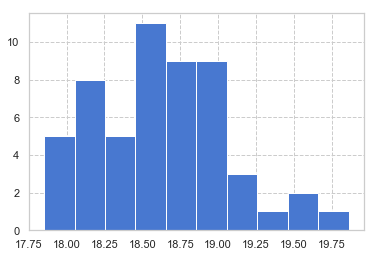

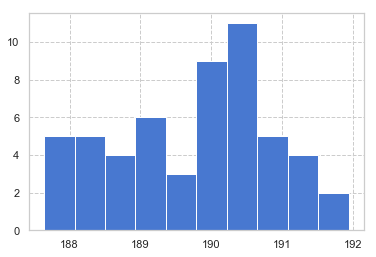

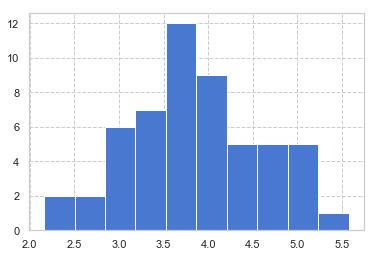

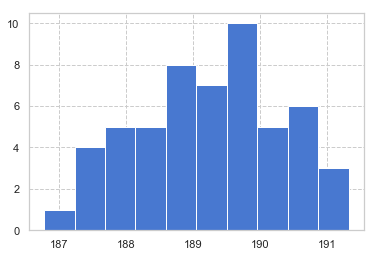

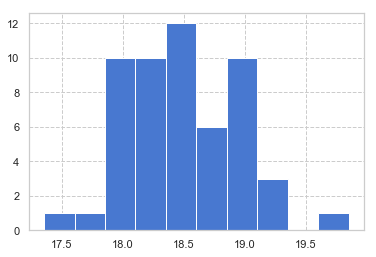

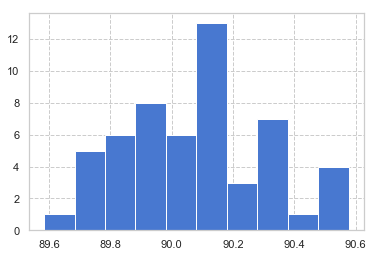

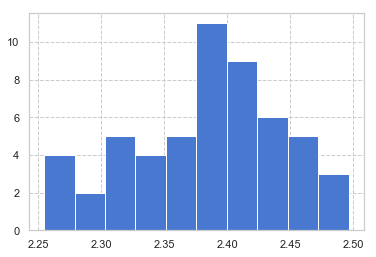

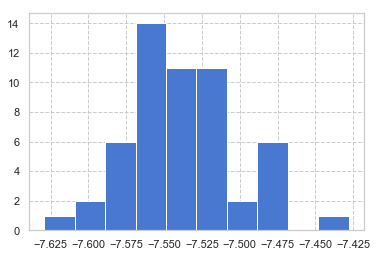

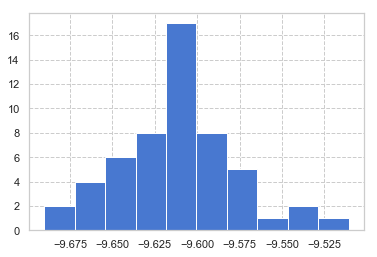

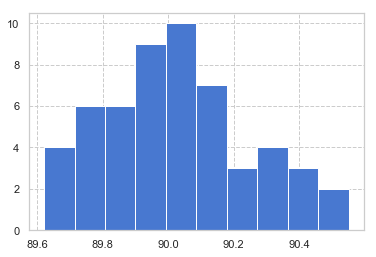

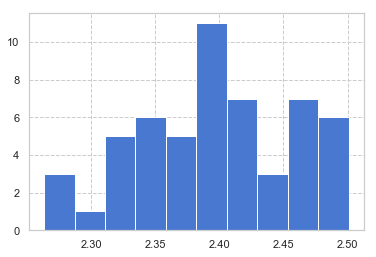

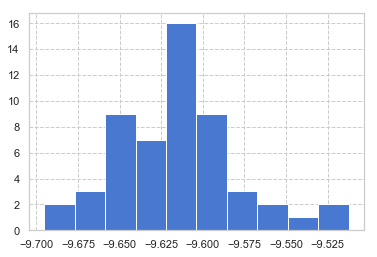

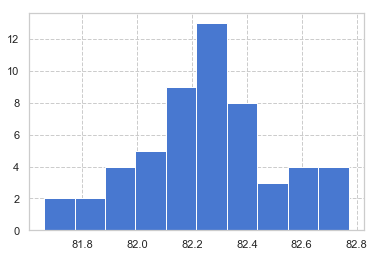

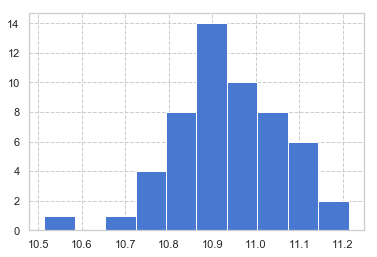

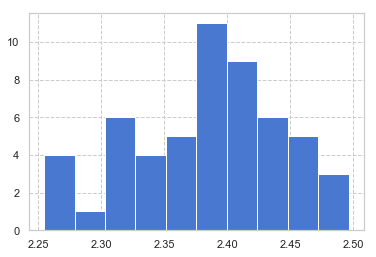

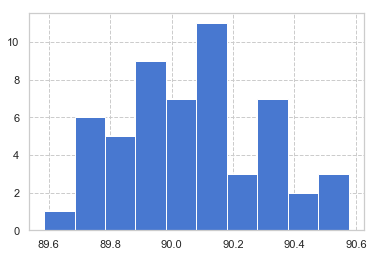

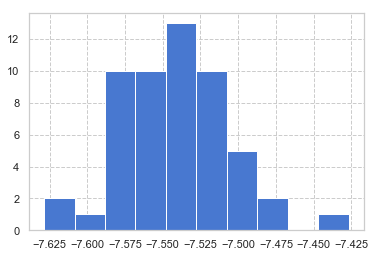

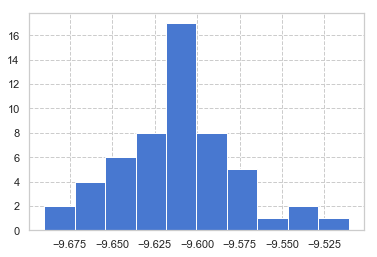

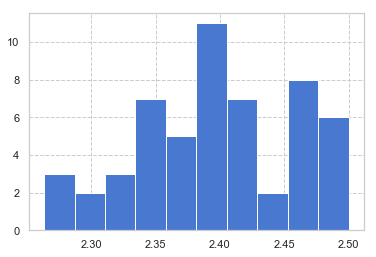

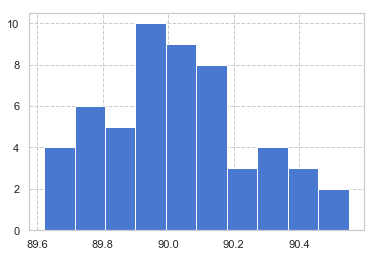

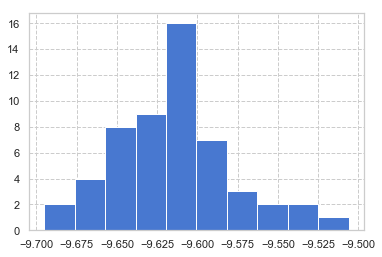

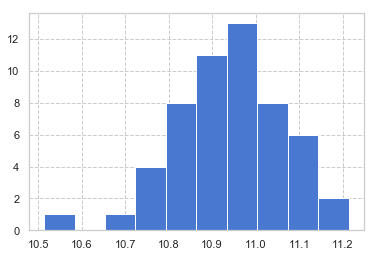

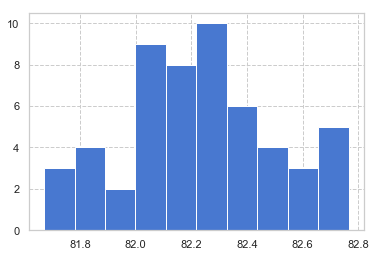

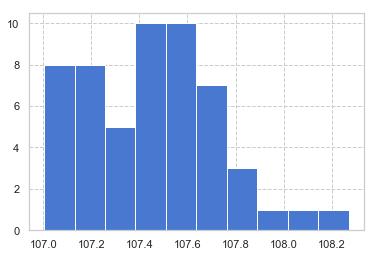

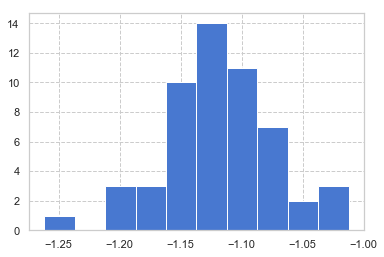

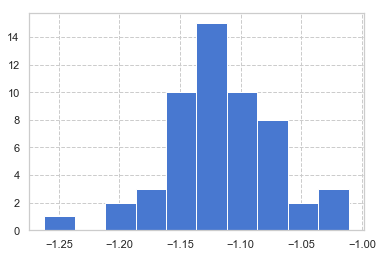

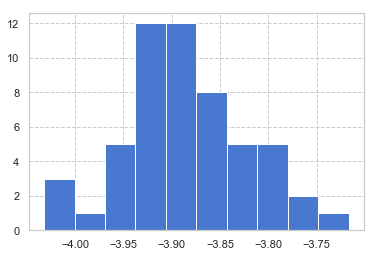

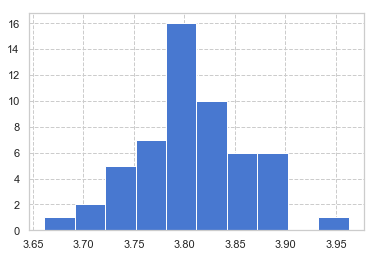

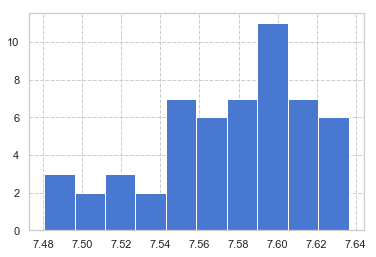

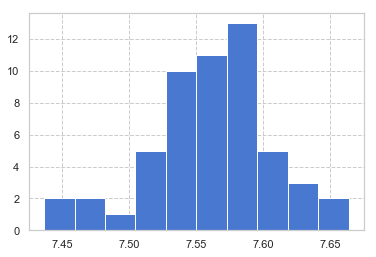

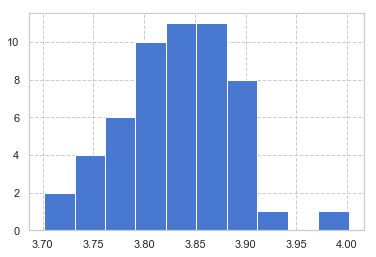

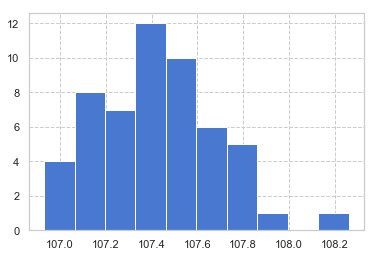

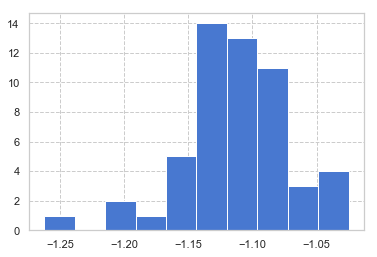

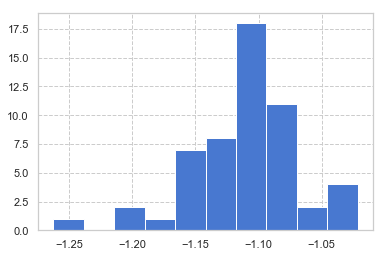

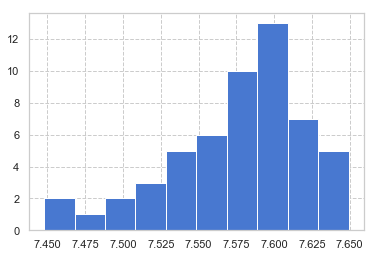

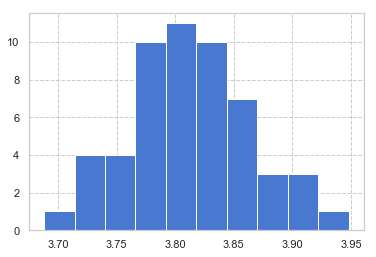

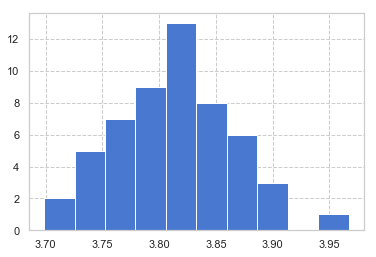

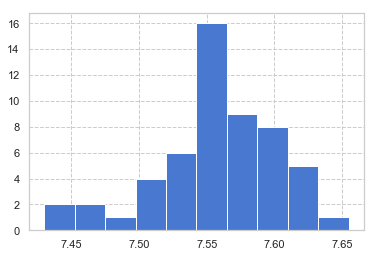

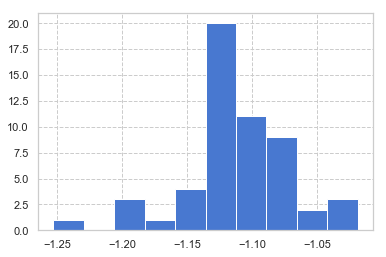

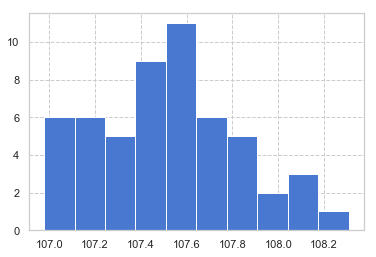

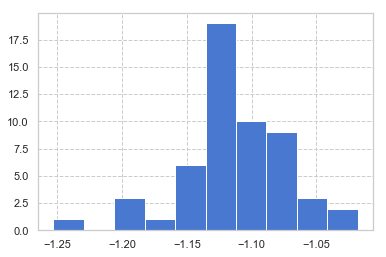

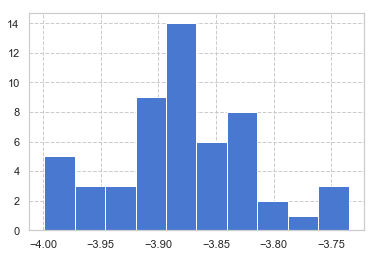

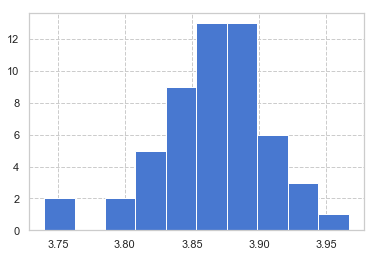

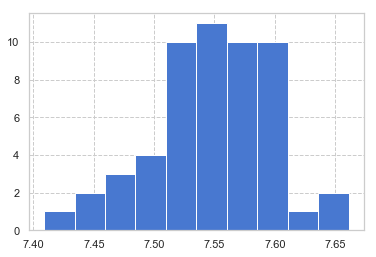

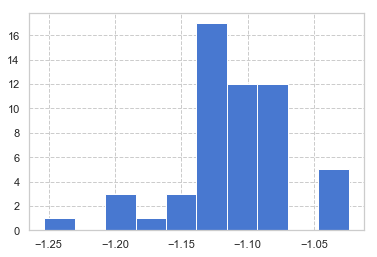

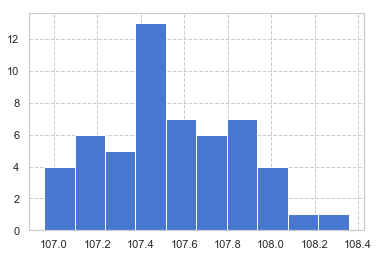

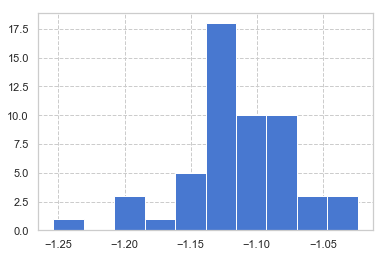

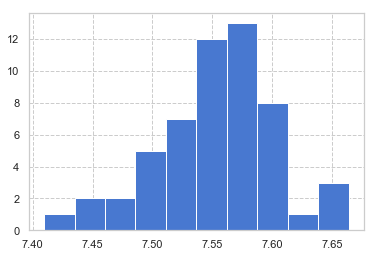

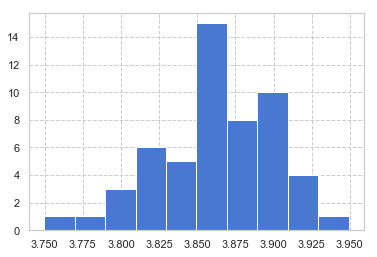

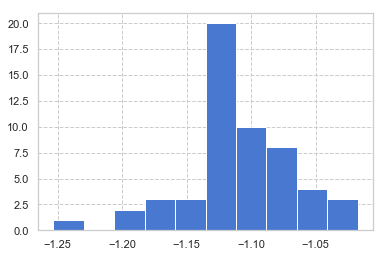

In [57]:
for i, d in submit_list_df.head(50).iterrows():
    d.hist()
    plt.show()

In [58]:
cor = submit_list_df.iloc[:, :len(sub_files)].corr()
cor 

,submission_t_v003_101_100,submission_t_v003_101_101,submission_t_v003_101_102,submission_t_v003_101_103,submission_t_v003_101_104,submission_t_v003_101_105,submission_t_v003_101_106,submission_t_v003_101_107,submission_t_v003_101_108,submission_t_v003_101_109,submission_t_v003_101_1329,submission_t_v003_101_1335,submission_t_v003_101_1336,submission_t_v003_101_1337,submission_t_v003_101_171,submission_t_v003_101_172,submission_t_v003_101_173,submission_t_v003_101_174,submission_t_v003_101_175,submission_t_v003_101_176,submission_t_v003_101_177,submission_t_v003_101_178,submission_t_v003_101_179,submission_t_v003_101_180,submission_t_v003_101_200,submission_t_v003_101_202,submission_t_v003_101_203,submission_t_v003_101_204,submission_t_v003_101_205,submission_t_v003_101_206,submission_t_v003_101_2089,submission_t_v003_101_2095,submission_t_v003_101_2096,submission_t_v003_101_2097,submission_t_v003_101_2119,submission_t_v003_101_2120,submission_t_v003_101_2121,submission_t_v003_101_2122,submission_t_v003_101_2123,submission_t_v003_101_2124,submission_t_v003_101_2125,submission_t_v003_101_2126,submission_t_v003_101_2127,submission_t_v003_101_2128,submission_t_v003_101_2219,submission_t_v003_101_2221,submission_t_v003_101_2223,submission_t_v003_101_2225,submission_t_v003_101_271,submission_t_v003_101_273,submission_t_v003_101_274,submission_t_v003_101_275,submission_t_v003_101_276
submission_t_v003_101_100,1.00000,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998
submission_t_v003_101_101,0.99999,1.00000,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998
submission_t_v003_101_102,0.99999,0.99999,1.00000,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998
submission_t_v003_101_103,0.99999,0.99999,0.99999,1.00000,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998
submission_t_v003_101_104,0.99999,0.99999,0.99999,0.99999,1.00000,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998
submission_t_v003_101_105,0.99999,0.99999,0.99999,0.99999,0.99999,1.00000,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.99998,0.99998,0.99998,0.99998,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99998,0.99999,0.9

In [59]:
sampled_id = submit_list_df.sample(frac=0.1).index.values

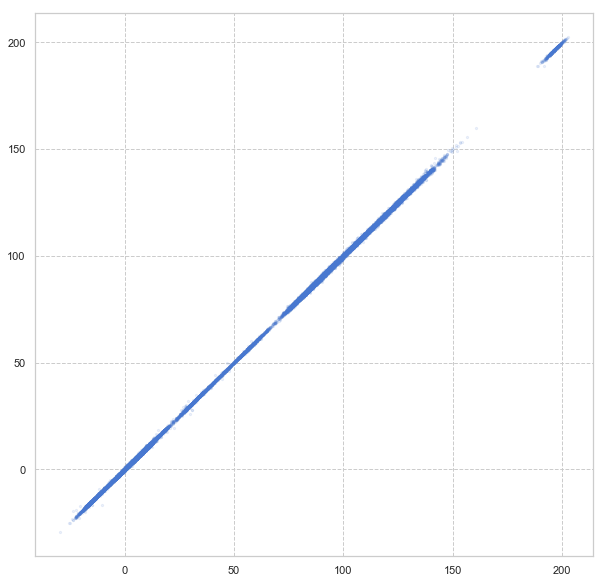

In [60]:
plt.figure(figsize=(10,10))
plt.scatter(x=submit_list_df.iloc[:, 0].loc[sampled_id], 
            y=submit_list_df.iloc[:, 7].loc[sampled_id], alpha=0.1, s= 5)

In [61]:
submit_df = submit_list_df[["mean_score"]]
submit_df.columns = ["scalar_coupling_constant"]

In [62]:
submit_df.head()

,scalar_coupling_constant
id,
4658147,18.62395
4658148,189.94193
4658149,3.77741
4658150,189.33895
4658151,18.46205


In [63]:
Path("../submit/ensemble").mkdir(parents=True, exist_ok=True)

In [64]:
sub_file_name = f'../submit/{DATA_VERSION}_{TRIAL_NO}/blending_{DATA_VERSION}_{TRIAL_NO}_{len(sub_files)}seeds.csv'
submit_df.to_csv(sub_file_name, index=True)
print(sub_file_name)

../submit/v003_101/blending_v003_101_53seeds.csv


In [66]:
!head ../submit/v003_101/blending_v003_101_53seeds.csv

id,scalar_coupling_constant
4658147,18.623951983419186
4658148,189.94192551848775
4658149,3.7774051253413523
4658150,189.33895267367484
4658151,18.462054490797325
4658152,90.08329794482472
4658153,2.3906644451835994
4658154,-7.540390522342074
4658155,-9.61203350619044


In [67]:
ls -ltr ../submit/v003_101/

total 8011480
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163129  8 25 07:07 submission_t_v003_101_2119.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164368  8 25 07:08 submission_t_v003_101_100.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163061  8 25 07:08 submission_t_v003_101_102.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164914  8 25 07:09 submission_t_v003_101_101.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165188  8 25 07:09 submission_t_v003_101_2120.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67166869  8 25 07:10 submission_t_v003_101_2121.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165057  8 25 07:10 submission_t_v003_101_103.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67166025  8 25 07:11 submission_t_v003_101_2123.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165088  8 25 07:11 submission_t_v003_101_105.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165029  8 25 07:12 submission_t_v003_101_2124.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165554 

In [68]:
#!kaggle competitions submit -c champs-scalar-coupling -f ../submit/v003_101/blending_v003_101_53seeds.csv -m "blending all data v003_101 53 seeds. blending_030.ipynb base:submission_t_v003_098_2069.csv"

100%|██████████████████████████████████████| 64.1M/64.1M [00:12<00:00, 5.51MB/s]
Successfully submitted to Predicting Molecular Properties

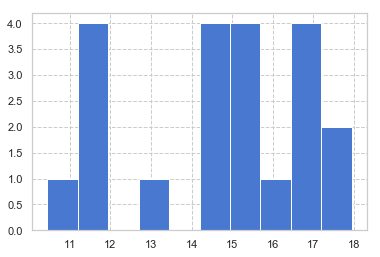

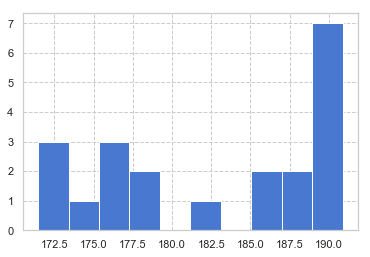

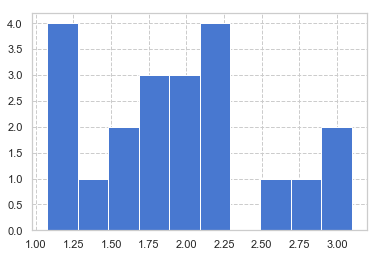

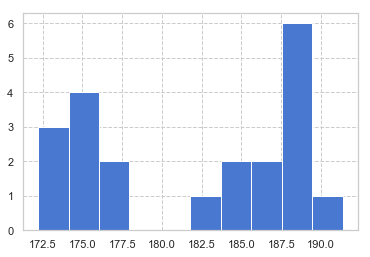

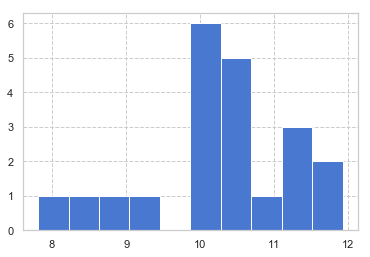

In [33]:
for i, d in submit_list_df.head().iterrows():
    d.hist()
    plt.show()

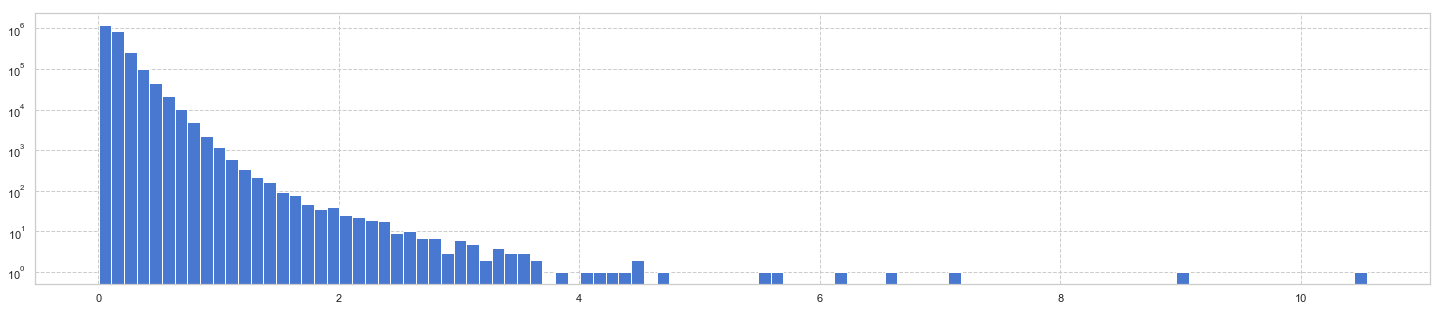

In [59]:

plt.figure(figsize=(25,5))
ax = plt.subplot(111)
cv_std.hist(ax=ax, bins=100)
plt.yscale("log")

In [38]:
cv_std = submit_list_df.std(axis=1)
cv_mean = submit_list_df.mean(axis=1)
cv_value = cv_std/cv_mean

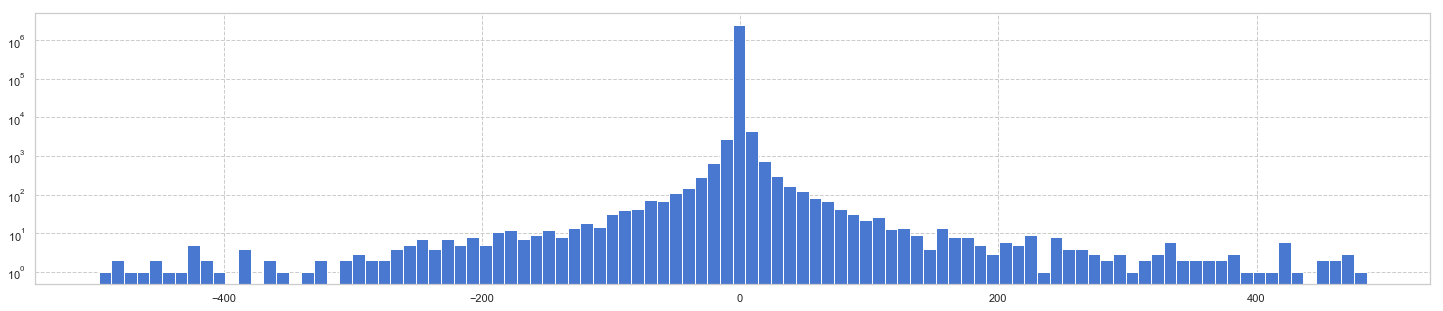

In [51]:
plt.figure(figsize=(25,5))
ax = plt.subplot(111)
cv_value[np.abs(cv_value) < 500].hist(ax=ax, bins=100)
plt.yscale("log")

In [47]:
np.abs(cv_value).sort_values(ascending=False)[:10]

id
5412746   219,716.34590
5465807   126,850.04206
5546431    85,100.91446
6552445    60,056.74870
5436786    18,762.42936
6942259    16,531.30469
4989294    13,911.01801
6462400    10,928.18863
4993772    10,377.60660
6114912     9,173.00372
dtype: float64

In [53]:
high_cv = cv_value[np.abs(cv_value) > 500]
high_cv

id
4698369     -6,946.80593
4710913        784.91746
4823283        918.63092
4825478      3,784.50219
4853540        576.83325
4882092       -623.90341
4892956      2,308.43802
4902768     -3,048.53894
4921967        633.81338
4935801        901.29538
4989294    -13,911.01801
4993772     10,377.60660
5085605     -2,476.27122
5098336        810.44443
5124395       -829.80919
5156635        595.45082
5169103     -6,183.53375
5181557      1,101.13801
5212243     -6,319.13448
5219726        734.34349
5241459      1,389.43887
5247798     -1,082.86622
5254630        556.98296
5263450        949.86269
5264679     -3,482.49522
5267715     -1,060.28821
5272631      1,867.69635
5307174      1,155.11992
5308095      4,925.84640
5335302      1,355.83248
5338066      2,875.03888
5397576      1,180.83817
5398959     -1,424.92753
5403209       -877.26486
5412746   -219,716.34590
5415657     -1,024.71457
5435504     -1,063.17269
5436786     18,762.42936
5465807   -126,850.04206
5467389     -1,476.073

In [55]:
submit_list_df_ = submit_list_df.copy()

In [56]:
submit_list_df_["std_score"] = submit_list_df_.std(axis=1)

In [58]:
submit_list_df_.loc[high_cv.index]

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,mean_score,std_score
id,,,,,,,,,,,,,,,,,,,,,,
4698369,-0.10891,0.20726,-0.19428,0.14164,0.10174,-0.10369,-0.11895,0.00188,-0.05684,-0.28368,0.19707,-0.10099,-0.11010,-0.20905,0.25207,0.25043,0.08866,0.02276,-0.20298,0.22548,-0.00002,0.16780
4710913,0.05207,0.08899,-0.15923,0.00470,-0.07532,-0.03570,-0.04131,-0.06193,-0.11053,-0.01497,0.12922,0.03613,0.09471,0.02362,0.05518,-0.02941,0.08073,-0.01844,0.06022,-0.07685,0.00009,0.07374
4823283,-0.11116,0.22432,-0.37545,0.60204,-0.13754,0.06240,0.20810,0.40585,-0.18211,0.04688,-0.19219,0.23043,-0.09052,0.17002,-0.45115,0.11842,0.21245,-0.58632,0.06607,-0.21436,0.00031,0.28427
4825478,-0.12516,0.18095,-0.14940,0.07228,0.02214,0.24390,-0.01154,-0.02196,-0.04942,-0.17620,-0.01985,-0.02738,0.14320,-0.24234,-0.01120,0.14124,-0.14500,0.06739,0.10497,0.00403,0.00003,0.12391
4853540,-0.15255,0.10124,-0.04742,-0.17721,0.16389,0.07497,0.10726,0.00017,-0.00006,0.29439,0.11748,0.14192,-0.06900,-0.02649,0.08587,-0.02954,0.00904,-0.21160,-0.26380,-0.11382,0.00024,0.13654
4882092,-0.06139,0.10911,-0.07718,-0.01266,-0.01576,0.05420,0.04878,0.04608,-0.06544,-0.01899,0.07845,-0.04549,-0.08414,0.01805,0.08898,0.01646,0.03799,0.01525,-0.02814,-0.10609,-0.00010,0.05986
4892956,0.13003,-0.04687,-0.26013,-0.14713,-0.15578,0.06756,-0.07169,0.21287,-0.07898,-0.16460,0.20092,0.13675,-0.02912,0.21120,0.01110,0.00870,-0.04994,0.03103,0.11166,-0.11639,0.00006,0.13327
4902768,-0.02569,-0.00599,0.01376,0.08220,0.12647,-0.11451,-0.00514,0.02718,-0.06584,-0.06934,0.02045,-0.06207,0.00658,0.05293,-0.03427,0.02239,0.01581,-0.07608,0.03884,0.05194,-0.00002,0.05731
4921967,-0.03500,-0.04545,-0.04124,0.03967,-0.00208,-0.05063,-0.07278,0.05059,0.05512,-0.05801,0.02634,-0.00415,-0.00704,0.07495,0.09477,0.01673,-0.01851,-0.05953,0.00821,0.02950,0.00007,0.04683


In [66]:
(cv_std>2).sum()

164

In [67]:
submit_list_df_[cv_std>2]

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,mean_score,std_score
id,,,,,,,,,,,,,,,,,,,,,,
4658147,14.42941,17.94441,17.13644,15.27704,15.10848,11.30809,16.10830,10.45234,17.09311,15.45748,14.73881,17.00781,17.35652,15.09924,14.48620,11.58494,16.53874,11.38786,11.89966,13.16861,14.67917,2.25488
4658148,185.88040,189.22815,177.96684,178.29521,189.48546,172.57653,185.81137,172.15734,187.75813,190.59805,176.24125,176.60991,189.97100,173.97079,189.41381,171.46370,176.38060,188.38959,189.59037,190.87225,182.63304,7.13280
4658150,185.21704,187.47601,177.79644,177.43159,187.79254,172.67824,185.47784,173.02363,186.61189,189.29749,175.51608,175.60289,188.88495,174.97048,188.24557,172.21388,175.36830,187.60289,188.22205,191.36174,182.03958,6.64369
4659320,33.08035,34.81430,26.73043,29.23484,27.54208,28.06737,28.00276,27.18509,28.28530,35.14333,26.87740,35.11687,28.20407,29.13082,27.81241,28.90023,27.67827,34.55264,27.81805,28.13963,29.61581,2.93531
4694991,132.74731,133.13240,133.94892,135.31686,131.07832,136.20143,133.15464,135.87478,134.11250,132.65901,138.71237,133.24406,135.62201,134.15559,132.68408,136.46895,135.20510,137.84316,132.81744,137.74618,134.63626,2.00375
4715174,141.75089,142.87002,147.99925,141.82936,147.58080,142.10264,146.31433,146.20726,141.97111,144.89666,146.48847,142.02606,141.62871,145.00860,142.72833,141.24091,144.34427,142.44431,143.81411,144.59190,143.89190,2.08879
4762582,34.66631,34.38711,39.29155,38.80190,38.87811,39.45968,38.91209,38.50681,33.65596,36.36730,38.52476,35.62383,35.08928,34.22979,39.19195,41.92236,38.23331,38.20737,38.30802,41.18223,37.67199,2.29767
4788766,132.34788,135.45968,133.93357,138.07553,130.82078,137.22836,132.82423,135.02552,134.61903,131.62559,139.94568,134.68519,134.67938,134.64871,133.76503,135.73918,133.26268,138.07366,134.19426,135.93369,134.84438,2.20111
4810197,29.24068,27.94773,27.78779,28.08638,27.99354,27.88377,32.53005,32.81597,31.96069,33.26076,27.82990,33.90253,32.63323,33.19148,27.69970,28.37092,28.09255,30.11552,28.61115,28.79332,29.93738,2.26515
